## Idea of the Project

<b>Intro</b>:
Give a theoretical introduction to the EKFs (and/or PFs), and then explore the algorithms of “filterpy” than can implement these EKFs (and/or PFs). 

<b>Data</b>:
Generate the data we are going to apply the filters to. We will uss a Github repo called “deeptime”.

<b>Implementation of the filters</b>:
Finally try to apply the algorithms to the data generated, in the same way as showed in example 10.3.1 of the pdf of the notes of the course.

<b>1st application</b>:
the Lorenz system

<b>2nd application</b>:
the Thomas attractor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
np.random.seed(0) #for reproducibility

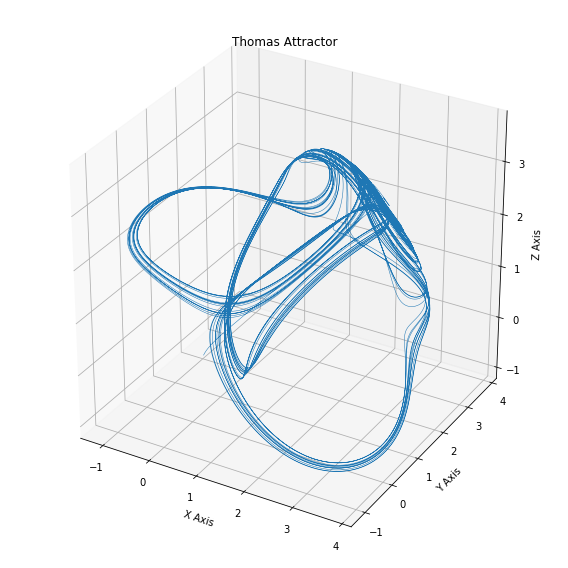

In [3]:
def thomas(xyz, *, b = 0.208):
    
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = np.sin(y) - b*x
    y_dot = np.sin(z) - b*y
    z_dot = np.sin(x) - b*z

    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 100000

xyzs = np.empty((num_steps + 1, 3))

xyzs[0] = (0.2, 0.1, 0.1)
#xyzs[0] = [np.random.randn(1)[0], np.random.randn(1)[0], np.random.randn(1)[0]]

for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + thomas(xyzs[i]) * dt

# Plot
ax = plt.figure(figsize = (8, 8)).add_subplot(projection = '3d')

ax.plot(*xyzs.T, lw = 0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Thomas Attractor")

plt.tight_layout()
plt.show()

What happens if I add a noise/perturbation to the starting point x0?

In [4]:
xyzs_pert = np.empty((num_steps + 1, 3))
sigma2 = 0.1
xyzs_pert[0] = (0.2, 0.1, 0.1) + sigma2*np.random.randn(1,3)

for i in range(num_steps):
    xyzs_pert[i + 1] = xyzs_pert[i] + thomas(xyzs_pert[i]) * dt

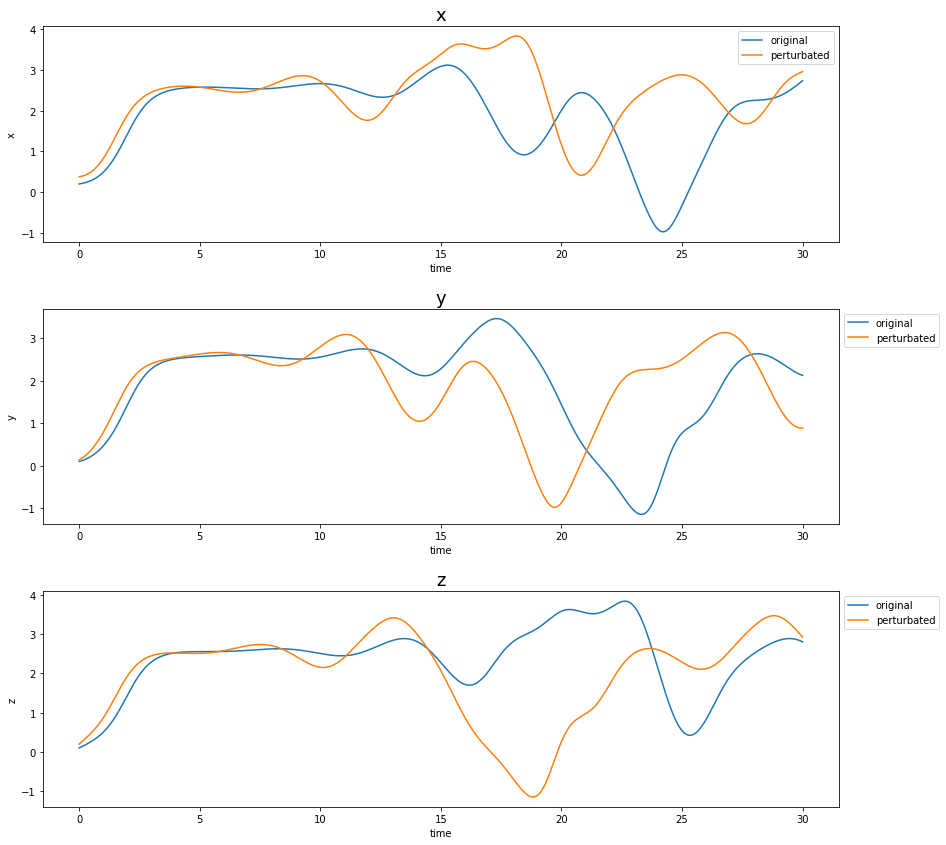

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
plt.rcParams.update({'font.size': 15})

x = xyzs[:5001,0]
y = xyzs[:5001,1]
z = xyzs[:5001,2]
x_pert = xyzs_pert[:5001,0]
y_pert = xyzs_pert[:5001,1]
z_pert = xyzs_pert[:5001,2]

axs[0].plot(np.linspace(0, 30, len(x)), x, label = 'original');
axs[0].plot(np.linspace(0, 30, len(x_pert)), x_pert, label = 'perturbated');
axs[0].set_title('x');
axs[0].set(ylabel = 'x');
axs[0].set(xlabel = 'time');

axs[1].plot(np.linspace(0, 30, len(y)), y, label = 'original');
axs[1].plot(np.linspace(0, 30, len(y_pert)), y_pert, label = 'perturbated');
axs[1].set_title('y');
axs[1].set(ylabel = 'y');
axs[1].set(xlabel = 'time');

axs[2].plot(np.linspace(0, 30, len(z)), z, label = 'original');
axs[2].plot(np.linspace(0, 30, len(z_pert)), z_pert, label = 'perturbated');
axs[2].set_title('z');
axs[2].set(ylabel = 'z');
axs[2].set(xlabel = 'time');

fig.tight_layout()

axs[0].legend(bbox_to_anchor=(1.0, 1.0), prop={'size':10}, fancybox=True);
axs[1].legend(bbox_to_anchor=(1.0, 1.0), prop={'size':10}, fancybox=True);
axs[2].legend(bbox_to_anchor=(1.0, 1.0), prop={'size':10}, fancybox=True);

# Implementation of the Kalman Filter

We start by generating the measurements, which is done by sampling points from the original system and adding some noise.

Note: in our case, for the way we generated the noise -> H = I

$$
\begin{aligned}
\text{Prior Knowledge}\\
\mathbf{H} &= \mathbf{I} \\
\\
\text{Predict Step}\\
\mathbf x_k &= \mathbf{F x}_{k-1} \\
\mathbf P_k &= \mathbf J \mathbf P_{k-1} \mathbf J^\mathsf T\\
\\
\text{Update Step}\\
\mathbf K_k &= \mathbf{P_k}(\mathbf{P_k}+\mathbf{R})^{-1} \\
\textbf y_k &= \mathbf z_k - \mathbf x_k \\
\mathbf x_k &=\mathbf{x_k} +\mathbf{K_k\textbf y_k} \\
\mathbf P_k &= (\mathbf{I}-\mathbf K_k)\mathbf{P_k}
\end{aligned}
$$

In [7]:
timestamp = np.linspace(0, 30, 51)

sigma3 = 0.3

x_noise = sigma3*np.random.randn(len(timestamp),1)
y_noise = sigma3*np.random.randn(len(timestamp),1)
z_noise = sigma3*np.random.randn(len(timestamp),1)

In [8]:
x_data = np.zeros((len(timestamp),))
y_data = np.zeros((len(timestamp),))
z_data = np.zeros((len(timestamp),))

dt = round(len(x)/(len(timestamp)-1))

In [9]:
for i in range(0, len(timestamp)):
    x_data[i] = x[i*dt]
    y_data[i] = y[i*dt]
    z_data[i] = z[i*dt]

In [10]:
# IMPORTANTE: generiamo le misure z in questo modo: z = x + noise, quindi matrice H = I

for i in range(0, len(timestamp)):
    x_data[i] = x_data[i] + x_noise[i]
    y_data[i] = y_data[i] + y_noise[i]
    z_data[i] = z_data[i] + z_noise[i]

In [11]:
x_data.shape

(51,)

Now we plot the measurements against the non perturbated process

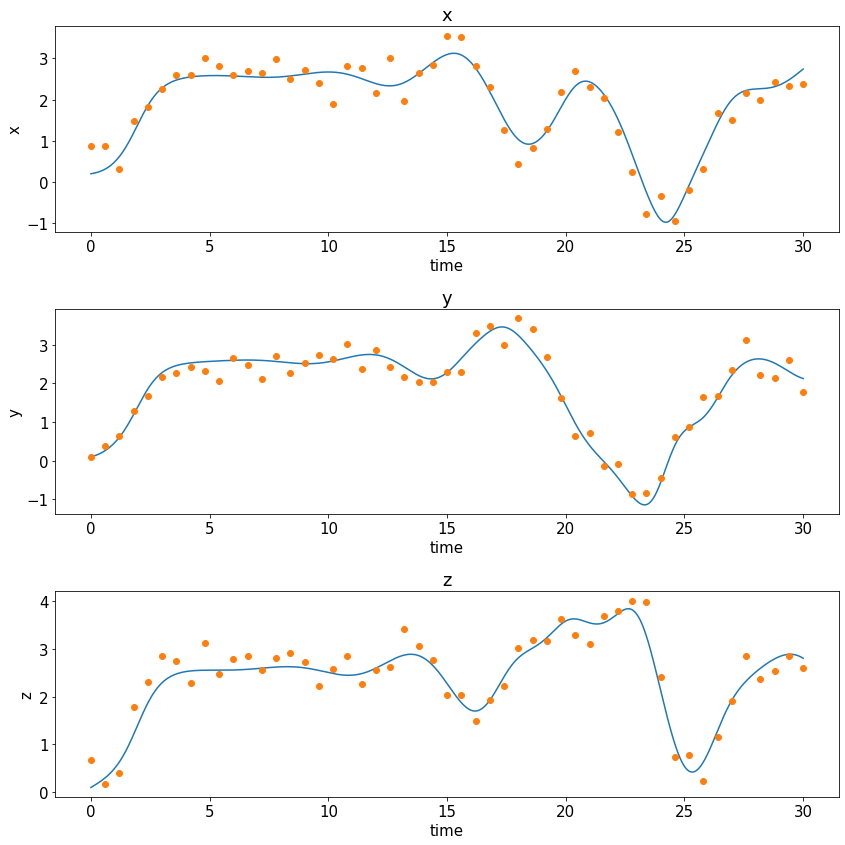

In [12]:
fig, axs = plt.subplots(3, 1, figsize = (12, 12))
plt.rcParams.update({'font.size': 15})

axs[0].plot(np.linspace(0, 30, len(x)), x);
axs[0].plot(timestamp, x_data, 'o')
axs[0].set_title('x');
axs[0].set(ylabel = 'x');
axs[0].set(xlabel = 'time');

axs[1].plot(np.linspace(0, 30, len(y)), y);
axs[1].plot(timestamp, y_data, 'o')
axs[1].set_title('y');
axs[1].set(ylabel = 'y');
axs[1].set(xlabel = 'time');

axs[2].plot(np.linspace(0, 30, len(z)), z);
axs[2].plot(timestamp, z_data, 'o')
axs[2].set_title('z');
axs[2].set(ylabel = 'z');
axs[2].set(xlabel = 'time');

fig.tight_layout()

In [13]:
b = 0.208

measurements = np.empty(shape = (3, len(timestamp)))

measurements[0,:] = x_data
measurements[1,:] = y_data
measurements[2,:] = z_data

In [14]:
def Jacobian_at(xyz, i):
    J = np.array([[-b               , np.cos(xyz[1, i]), 0],
                  [0                , -b               , np.cos(xyz[2, i])],
                  [np.cos(xyz[0, i]), 0                , -b]])
    return J

$$
\begin{aligned}
\text{Prior Knowledge}\\
\mathbf{H} &= \mathbf{I} \\
\\
\text{Predict Step}\\
\mathbf x_k &= \mathbf{F x}_{k-1} \\
\mathbf P_k &= \mathbf J \mathbf P_{k-1} \mathbf J^\mathsf T+\mathbf Q\\
\\
\text{Update Step}\\
\mathbf K_k &= \mathbf{P_k}(\mathbf{P_k}+\mathbf{R_k})^{-1} \\
\textbf y_k &= \mathbf z_k - \mathbf x_k \\
\mathbf x_k &=\mathbf{x_k} +\mathbf{K_k\textbf y_k} \\
\mathbf P_k &= (\mathbf{I}-\mathbf K_k)\mathbf{P_k}
\end{aligned}
$$

In [15]:
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import ExtendedKalmanFilter

We now build all the things we need to implement the EKF

In [16]:
filtered = np.empty(shape = (3, len(timestamp)))
forecast = np.empty(shape = (3, len(timestamp)))

filtered[:, 0] = xyzs_pert[0]
inter_dt = 0.001

# we set F to the its initial value
F = Jacobian_at(filtered, 0)

# R is the covariance matrix for measurement noise -> we assume the noise indipendent, with variance = 4
R = sigma3*np.eye(3)

# then we decided to explore the Q_dsicrete_white_noise function "from filterpy"
Q = Q_discrete_white_noise(3, dt, 0.001)

# P -> state covariance: we specify initial P based on our belief, then it goes updating
# come inizializzare P -> incertezza iniziale, quindi mi immagino una matrice identita'
P = 1/5*np.eye(3)
# P = np.diag([np.random.randn(1)[0], np.random.randn(1)[0], np.random.randn(1)[0]])

Given these parameters, we can now implement the EKF

In [17]:
# the EKF loop

for i in range(1, len(timestamp)):
    
    F = Jacobian_at(filtered, i-1)
    
    tspan = np.linspace(0, 1, round(1/inter_dt))
    local_sol = np.empty(shape = (3, len(tspan)))
    local_sol[:, 0] = filtered[:, i-1]
    
    
    for j in range (1, len(tspan)):
        local_sol[:, j] = local_sol[:, j-1] + thomas(local_sol[:, j-1])*inter_dt  ## xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt
    
    forecast[:, i] = local_sol[:, len(tspan)-1]
    
    P = F @ P @ F.T + Q
    
    # How should I compute K? 2 options:
    
    # formula on the KF book:
    
    K = P @ np.linalg.inv(P + R)
    
    print(K[0][0])
    print(K[1][1])
    print(K[2][2])
    print(" ")
    
    residual = measurements[:, i] - forecast[:, i]
    filtered[:, i] = forecast[:, i] + K @ residual
    
    P = (np.eye(3) - K) @ P
    
    #print(P[0][0])
    #print(P[1][1])
    #print(P[2][2])
    print(" ")
    
    

0.9997473648136995
0.3993398887107772
0.372991252120118
 
 
0.9996916084835443
0.2597008101476309
0.2985378887909231
 
 
0.9996348282600656
0.1173952448182783
0.476933636891686
 
 
0.9995903224777245
0.005935060790824857
0.028825031408376178
 
 
0.9995912038885324
0.008023237233356236
0.05159704224798626
 
 
0.9996023994634577
0.0359265305551677
0.2835778684178946
 
 
0.9996646061935592
0.19106011310752433
0.42525658996564986
 
 
0.9996729237559517
0.2117586879555931
0.42656115055654076
 
 
0.9996954924932668
0.26821706372741644
0.4990475344303234
 
 
0.9996747831805869
0.21642357525626602
0.47545760132712045
 
 
0.9996844166990665
0.24044649356394945
0.43060570398469566
 
 
0.9996927123761105
0.26123029151378385
0.4497991419033704
 
 
0.9996869201685521
0.2467308599548654
0.4372740354688774
 
 
0.9996920645815924
0.25965821179066
0.4980503414821223
 
 
0.9996981890441672
0.2747938064558211
0.39803706288618756
 
 
0.9996887908591672
0.25147443508904893
0.45599322801489783
 
 
0.9996714

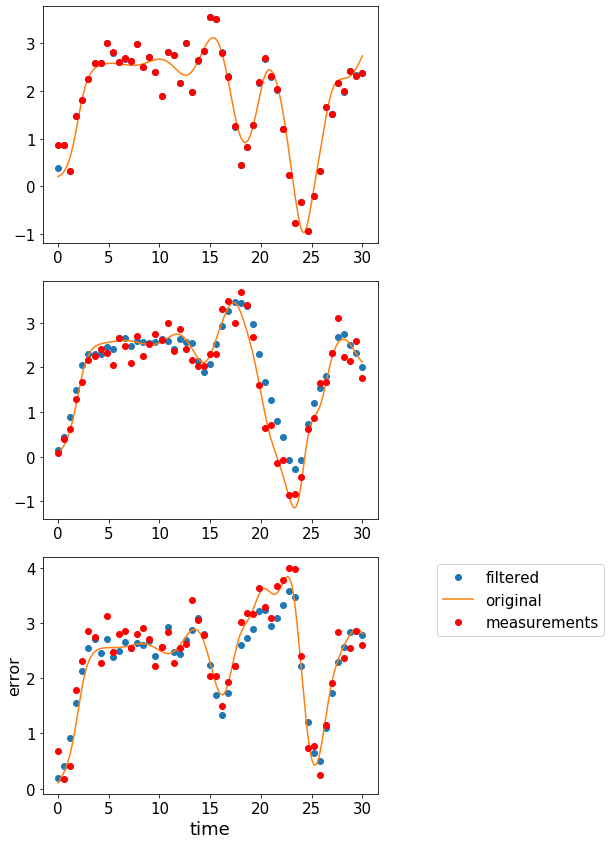

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(timestamp, filtered[0,:], 'o', label = 'filtered')
axs[0].plot(np.linspace(0, 30, len(x)), x, label = 'original')
axs[0].plot(timestamp, x_data, 'ro', label = 'measurements')
axs[1].plot(timestamp, filtered[1,:], 'o', label = 'filtered')
axs[1].plot(np.linspace(0, 30, len(y)), y, label = 'original')
axs[1].plot(timestamp, y_data, 'ro', label = 'measurements')
axs[2].plot(timestamp, filtered[2,:], 'o', label = 'filtered')
axs[2].plot(np.linspace(0, 30, len(z)), z, label = 'original')
axs[2].plot(timestamp, z_data, 'ro', label = 'measurements')

plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()

# Error

We now plot and compare the two errors:

- blue line: the error of the evolution of the dynamical model starting froma perturbated point
    
- orange dots: the error between the points generated bu our EKF and the "real" dynamical system
    


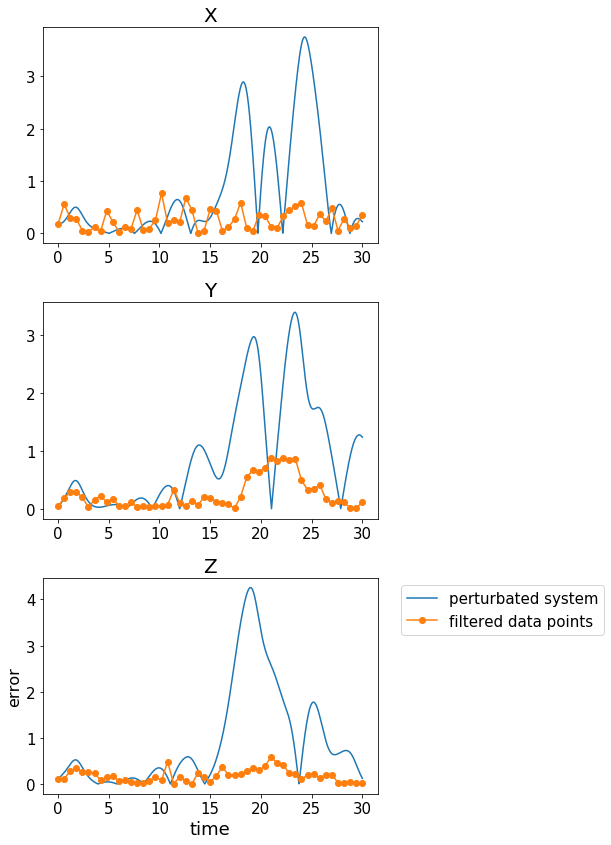

In [19]:
# error at point 1
error_pert_x = np.abs(x - x_pert)
error_pert_y = np.abs(y - y_pert)
error_pert_z = np.abs(z - z_pert)

# error at point 2
error_filtered_x = np.empty(shape = len(timestamp))
error_filtered_y = np.empty(shape = len(timestamp))
error_filtered_z = np.empty(shape = len(timestamp))


for i in range(0, len(timestamp)):
    error_filtered_x[i] = np.abs(x[i*dt] - filtered[0, i])
    error_filtered_y[i] = np.abs(y[i*dt] - filtered[1, i])
    error_filtered_z[i] = np.abs(z[round(len(x)/(len(timestamp)-1))*i] - filtered[2, i])

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(np.linspace(0, 30, len(x)), error_pert_x, label = 'perturbated system')
axs[0].plot(timestamp, error_filtered_x, '-o', label = 'filtered data points')
axs[0].set_title('X', fontsize = 20)
axs[1].plot(np.linspace(0, 30, len(y)), error_pert_y, label = 'perturbated system')
axs[1].plot(timestamp, error_filtered_y, '-o', label = 'filtered data points')
axs[1].set_title('Y', fontsize = 20)
axs[2].plot(np.linspace(0, 30, len(z)), error_pert_z, label = 'perturbated system')
axs[2].plot(timestamp, error_filtered_z, '-o', label = 'filtered data points')
axs[2].set_title('Z', fontsize = 20)

plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()

In [20]:
filtered_RK4 = np.empty(shape = (3, len(timestamp)))
forecast_RK4 = np.empty(shape = (3, len(timestamp)))

filtered_RK4[:, 0] = xyzs_pert[0]
inter_dt_RK4 = 0.01

In [21]:
# the EKF loop

for i in range(1, len(timestamp)):
    
    F = Jacobian_at(filtered_RK4, i-1)
    
    tspan = np.linspace(0, 1, round(1/inter_dt_RK4))
    local_sol_RK4 = np.empty(shape = (3, len(tspan)))
    local_sol_RK4[:, 0] = filtered_RK4[:, i-1]
    
    for j in range (1, len(tspan)):
        k1 = thomas(local_sol_RK4[:, j-1])
        k2 = thomas(local_sol_RK4[:, j-1]) + k1 * inter_dt_RK4 / 2
        k3 = thomas(local_sol_RK4[:, j-1]) + k2 * inter_dt_RK4 / 2
        k4 = thomas(local_sol_RK4[:, j-1]) + k3 * inter_dt_RK4 / 2
        local_sol_RK4[:, j] = local_sol_RK4[:, j-1] + (inter_dt_RK4/6)*(k1+2*k2+2*k3+k4)
    
    forecast_RK4[:, i] = local_sol_RK4[:, len(tspan)-1]
    
    P = F @ P @ F.T + Q
    K = P @ np.linalg.inv(P + R)
    #K = 0.5*np.eye(3)
    
    print(K[0][0])
    print(K[1][1])
    print(K[2][2])
    print(" ")
    
    residual = measurements[:, i] - forecast_RK4[:, i]
    filtered_RK4[:, i] = forecast_RK4[:, i] + K @ residual
    
    P = (np.eye(3) - K) @ P    
    

0.9996822526215328
0.2361645536398358
0.4669105432825735
 
0.9997063594184387
0.2967745473177597
0.299602036716913
 
0.9996384946881226
0.12656047167391252
0.47681568113711487
 
0.9995907185946447
0.006954825348233901
0.028680877992114488
 
0.9995909411156294
0.007368749534036413
0.05181615824806571
 
0.9996021787679609
0.03537513002463758
0.28371551176430365
 
0.9996641104972595
0.18982186424622263
0.42526200551658877
 
0.9996725793314687
0.2108984747516521
0.4265394214799662
 
0.9996954486854434
0.26810757476457964
0.49904299834563226
 
0.9996749009861131
0.21671775830570536
0.47545368166297125
 
0.9996844826505071
0.24061125784228482
0.430611243634146
 
0.9996926971861149
0.2611923633333247
0.44980376753298296
 
0.9996868991028447
0.24667822031659187
0.4372766530856891
 
0.999692068054872
0.25966685611135504
0.4980511172277946
 
0.9996981986725761
0.274817820912109
0.3980470733448088
 
0.99968878156451
0.2514511933139274
0.4559962060739448
 
0.9996714470000072
0.20800616076110884
0.

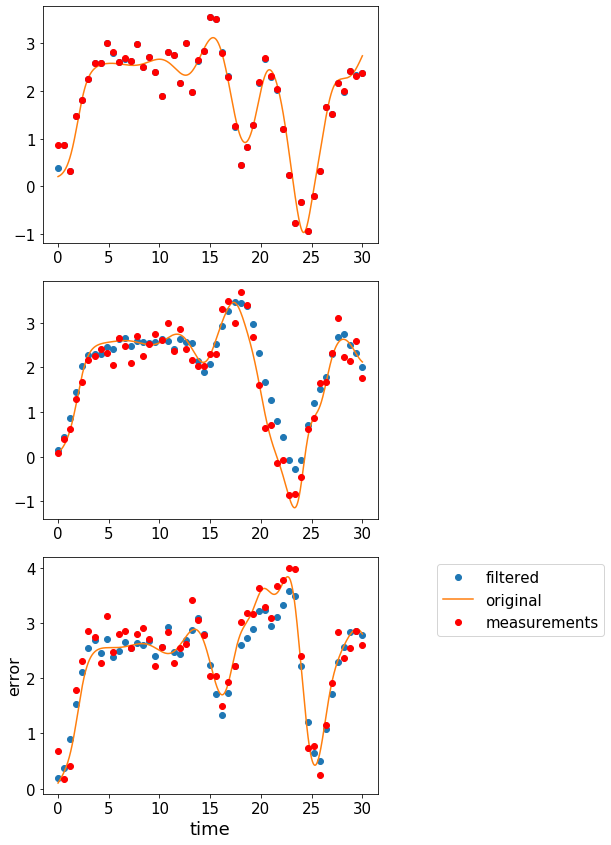

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(timestamp, filtered_RK4[0,:], 'o', label = 'filtered')
axs[0].plot(np.linspace(0, 30, len(x)), x, label = 'original')
axs[0].plot(timestamp, x_data, 'ro', label = 'measurements')
axs[1].plot(timestamp, filtered_RK4[1,:], 'o', label = 'filtered')
axs[1].plot(np.linspace(0, 30, len(y)), y, label = 'original')
axs[1].plot(timestamp, y_data, 'ro', label = 'measurements')
axs[2].plot(timestamp, filtered_RK4[2,:], 'o', label = 'filtered')
axs[2].plot(np.linspace(0, 30, len(z)), z, label = 'original')
axs[2].plot(timestamp, z_data, 'ro', label = 'measurements')

plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()

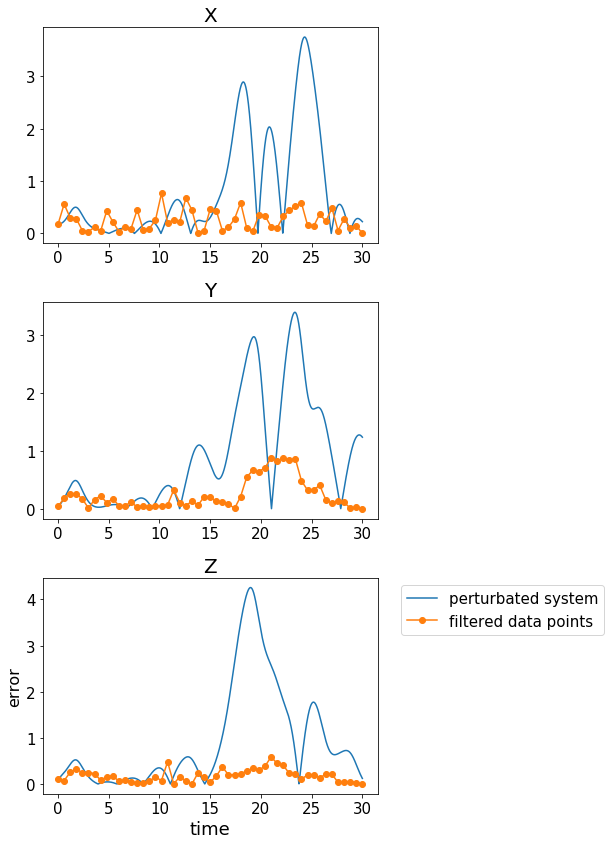

In [23]:
# error at point 1
error_pert_x = np.abs(x - x_pert)
error_pert_y = np.abs(y - y_pert)
error_pert_z = np.abs(z - z_pert)

# error at point 2
error_filtered_x_RK4 = np.empty(shape = len(timestamp))
error_filtered_y_RK4 = np.empty(shape = len(timestamp))
error_filtered_z_RK4 = np.empty(shape = len(timestamp))


for i in range(0, len(timestamp) - 1):
    error_filtered_x_RK4[i] = np.abs(x[dt*i] - filtered_RK4[0, i])
    error_filtered_y_RK4[i] = np.abs(y[dt*i] - filtered_RK4[1, i])
    error_filtered_z_RK4[i] = np.abs(z[dt*i] - filtered_RK4[2, i])

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(np.linspace(0, 30, len(x)), error_pert_x, label = 'perturbated system')
axs[0].plot(timestamp, error_filtered_x_RK4, '-o', label = 'filtered data points')
axs[0].set_title('X', fontsize = 20)
axs[1].plot(np.linspace(0, 30, len(y)), error_pert_y, label = 'perturbated system')
axs[1].plot(timestamp, error_filtered_y_RK4, '-o', label = 'filtered data points')
axs[1].set_title('Y', fontsize = 20)
axs[2].plot(np.linspace(0, 30, len(z)), error_pert_z, label = 'perturbated system')
axs[2].plot(timestamp, error_filtered_z_RK4, '-o', label = 'filtered data points')
axs[2].set_title('Z', fontsize = 20)

plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()

# Particle Filter: the Ensemble Kalman Filter

Since the *filterpy* book didn't provide an exhaustive implementation of the Ensemble Kalman Filter (EnKF), we decided to rely on this paper written by two researchers of Oklahoma State University:

PyDA: A Hands-On Introduction to Dynamical Data
Assimilation with Python

https://www.osti.gov/pages/servlets/purl/1737509

In [24]:
from numpy.random import randn
from numpy.random import multivariate_normal

In [25]:
def EnKF(filtered_points, N, measurements, P, R, Q, k):
    
    n = 3   # n is the state dimension 
    
    # compute the mean of forecast ensemble
    ub = np.mean(filtered_points, axis = 1)
    
    # compute Jacobian of observation operator at ub
    
    F = Jacobian_at(filtered, k-1)
    
    # compute Kalman gain
    
    P = F @ P @ F.T + Q
   
    K = P @ np.linalg.inv(P + R)
    
    print(" Sto stampando K ")
    print(K)
    print(" ")
    
    wi = np.zeros([3, N])
    uai = np.zeros([3, N])
    
    for i in range(N):
        # create virtual observations
        wi[:, i] = measurements + np.random.multivariate_normal(np.zeros(3), R)
        # compute analysis ensemble
        filtered_points[:, i] = filtered_points[:, i] + K @ (wi[:, i] - filtered_points[:, i])
        
    # compute the mean of analysis ensemble
    ua = np.mean(filtered_points, axis = 1)

    # compute analysis error covariance matrix
    P = (1/(N-1)) * (filtered_points - ua.reshape(-1, 1)) @ (filtered_points - ua.reshape(-1, 1)).T

    return filtered_points, P


In [26]:
########################### Data Assimilation #################################

######### Change of names from the paper #####
# nt -> len(timestamp)
# solution paper:
#        ub -> forecast_mean
#        ua -> filtered_mean
#        uai -> processed_points
# B -> P
###############################

n = 3   # state dimension
m = 3   # measurement dimension
N = 200 # ensemble size

list_filtered = []
list_filtered.clear()
list_filtered_x = np.zeros(shape = (N, len(timestamp))) # I keep track of this points to plot them after --> (their evolution is shown through the green +)

#timestamp = np.linspace(0, 30, 40)

P = 0.3*np.eye(3)
Q = 0.0*np.eye(3) # Q = 0, this means that we don't add any noise in the "Predict Step"
R = sigma2*np.eye(3)

#time integration
forecast_mean = np.empty(shape = (3, len(timestamp)))
processed_mean = np.empty(shape = (3, len(timestamp)))
forecast_mean[:, 0] = xyzs[0]
processed_mean[:, 0] = xyzs[0]   # by the very meaning of our initialization

#initialize ensemble
processed_points = np.zeros([3, N+1])   # are the N points (every N has 3 points, fro x, y and z) 
                                      # we are going to process them by applying the algorithm to each of them
for i in range(N):
    processed_points[:, i] = xyzs[0] + np.random.multivariate_normal(np.zeros(n), P)  # initialize the vector of evolving point 
    list_filtered_x[i, 0] = processed_points[0, i]                                    # initialize also the list containg the record of evolution of all points

inter_dt = 0.01
tspan = np.linspace(0, 30/len(timestamp), round(1/inter_dt))

for k in range(1, len(timestamp)):

# Forecast Step -> local solution with  Forward Euler 
    
    for i in range(N):
        # forecast ensemble
        local_sol = np.empty(shape = (3, len(tspan)))
        local_sol[:, 0] = processed_points[:, i]
        for j in range (1, len(tspan)):
            local_sol[:, j] = local_sol[:,j-1] + thomas(local_sol[:, j-1])*inter_dt 

        processed_points[:, i] = local_sol[:, len(tspan) - 1]

    # compute the mean of forecast ensemble
    forecast_mean[:, k] = np.mean(processed_points, axis = 1)

    # compute forecast error covariance matrix
    P = (1/(N-1))*(processed_points-forecast_mean[:, k].reshape(-1,1))@(processed_points-forecast_mean[:, k].reshape(-1,1)).T
  
    print (" Sto stampando P ")
    print(P)
    
    # Analysis Step (Application of the EnKF)
    processed_points, P = EnKF(processed_points, N, measurements[:, k], P, R, Q, k)
    

    for i in range(N):
        list_filtered_x[i, k] = processed_points[0, i]
    
    # compute the mean of analysis ensemble
    processed_mean[:, k] = np.mean(processed_points, axis = 1)        
        

 Sto stampando P 
[[0.39227981 0.29168632 0.30108841]
 [0.29168632 0.36070792 0.27714309]
 [0.30108841 0.27714309 0.38720005]]
 Sto stampando K 
[[0.62219226 0.09806022 0.12177686]
 [0.09806022 0.6493641  0.11314714]
 [0.12177686 0.11314714 0.60179946]]
 
 Sto stampando P 
[[0.11167228 0.09929355 0.08784052]
 [0.09929355 0.11434745 0.08994933]
 [0.08784052 0.08994933 0.09637292]]
 Sto stampando K 
[[0.31374774 0.1631098  0.12973789]
 [0.1631098  0.28091417 0.09783611]
 [0.12973789 0.09783611 0.16285458]]
 
 Sto stampando P 
[[0.08004578 0.07414631 0.07268522]
 [0.07414631 0.07782924 0.07271701]
 [0.07268522 0.07271701 0.0772755 ]]
 Sto stampando K 
[[0.09641617 0.06914687 0.12483882]
 [0.06914687 0.09121519 0.11812202]
 [0.12483882 0.11812202 0.28325837]]
 
 Sto stampando P 
[[0.04965191 0.04235263 0.03934233]
 [0.04235263 0.04173679 0.03555359]
 [0.03934233 0.03555359 0.04269157]]
 Sto stampando K 
[[0.00980565 0.00983174 0.0043526 ]
 [0.00983174 0.01447766 0.00561963]
 [0.0043526  0.

 Sto stampando P 
[[ 0.11211587 -0.09181199  0.09177957]
 [-0.09181199  0.1496129  -0.03576181]
 [ 0.09177957 -0.03576181  0.10474659]]
 Sto stampando K 
[[ 0.52333919  0.02786328  0.07475231]
 [ 0.02786328  0.47329864 -0.00759724]
 [ 0.07475231 -0.00759724  0.01612414]]
 
 Sto stampando P 
[[ 0.07675233 -0.03147503  0.05112905]
 [-0.03147503  0.10174845 -0.00372046]
 [ 0.05112905 -0.00372046  0.07417234]]
 Sto stampando K 
[[ 0.27468589  0.09385927 -0.03357111]
 [ 0.09385927  0.38201533  0.17909299]
 [-0.03357111  0.17909299  0.23065828]]
 
 Sto stampando P 
[[ 0.06370937  0.02202337  0.02646008]
 [ 0.02202337  0.08307396 -0.01100682]
 [ 0.02646008 -0.01100682  0.07104213]]
 Sto stampando K 
[[0.02892473 0.02022986 0.08135931]
 [0.02022986 0.36954508 0.15930126]
 [0.08135931 0.15930126 0.33915875]]
 
 Sto stampando P 
[[ 0.10473513  0.08023885 -0.02006684]
 [ 0.08023885  0.09202345 -0.05627499]
 [-0.02006684 -0.05627499  0.10858092]]
 Sto stampando K 
[[0.02177597 0.05354136 0.0011659

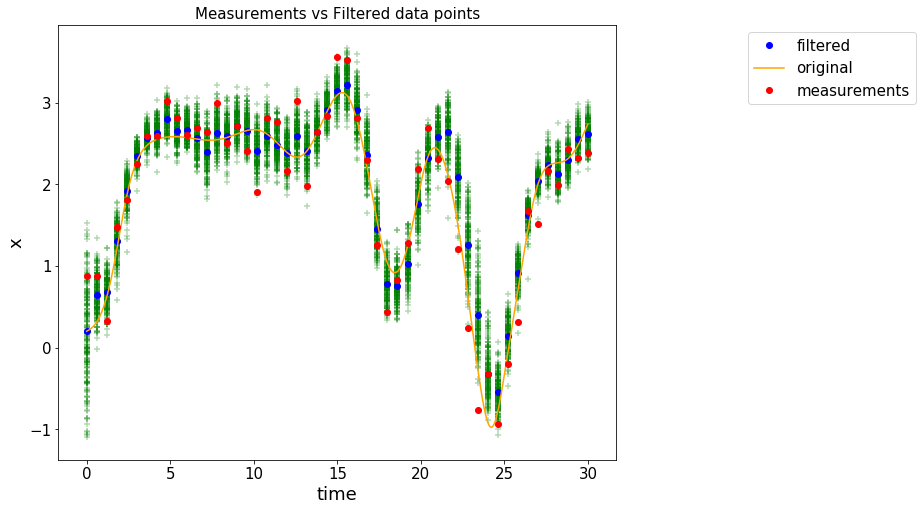

In [27]:
plt.rcParams['figure.figsize'] = [10, 8]

plt.plot(timestamp, processed_mean[0,:], 'o', label = 'filtered', c = 'blue')
plt.plot(np.linspace(0, 30, 5001), x, label = 'original', c = 'orange')
plt.plot(timestamp, x_data, 'ro', label = 'measurements')

for k in range(0, len(timestamp)):
    plt.scatter(timestamp[k]*np.ones(N), list_filtered_x[:, k], alpha = 0.3, marker = '+', c = 'green')
    
plt.title('Measurements vs Filtered data points', fontsize = 15)
plt.xlabel('time', fontsize = 18)
plt.ylabel('x', fontsize = 18)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.55, 1))

fig.tight_layout()

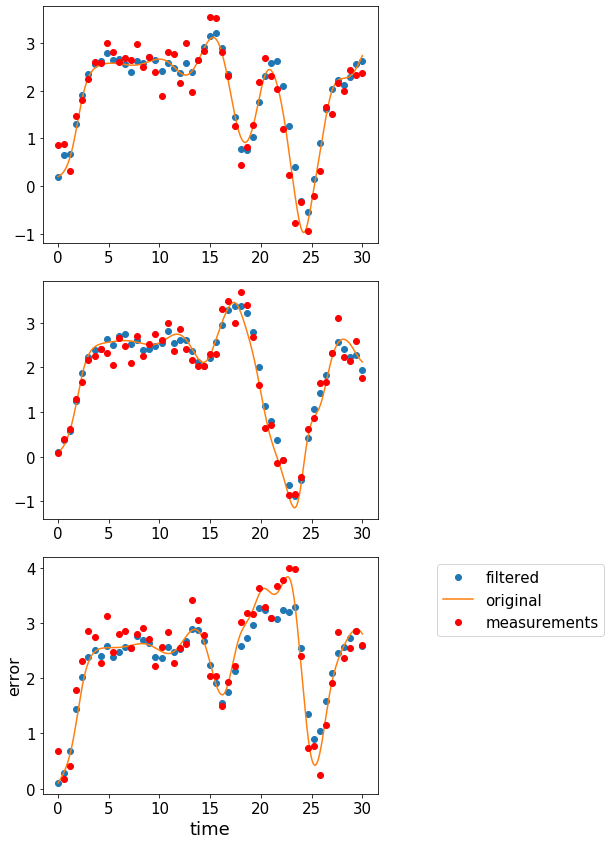

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(timestamp, processed_mean[0,:], 'o', label = 'filtered')
axs[0].plot(np.linspace(0, 30, len(x)), x, label = 'original')
axs[0].plot(timestamp, x_data, 'ro', label = 'measurements')
axs[1].plot(timestamp, processed_mean[1,:], 'o', label = 'filtered')
axs[1].plot(np.linspace(0, 30, len(y)), y, label = 'original')
axs[1].plot(timestamp, y_data, 'ro', label = 'measurements')
axs[2].plot(timestamp, processed_mean[2,:], 'o', label = 'filtered')
axs[2].plot(np.linspace(0, 30, len(z)), z, label = 'original')
axs[2].plot(timestamp, z_data, 'ro', label = 'measurements')

plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()

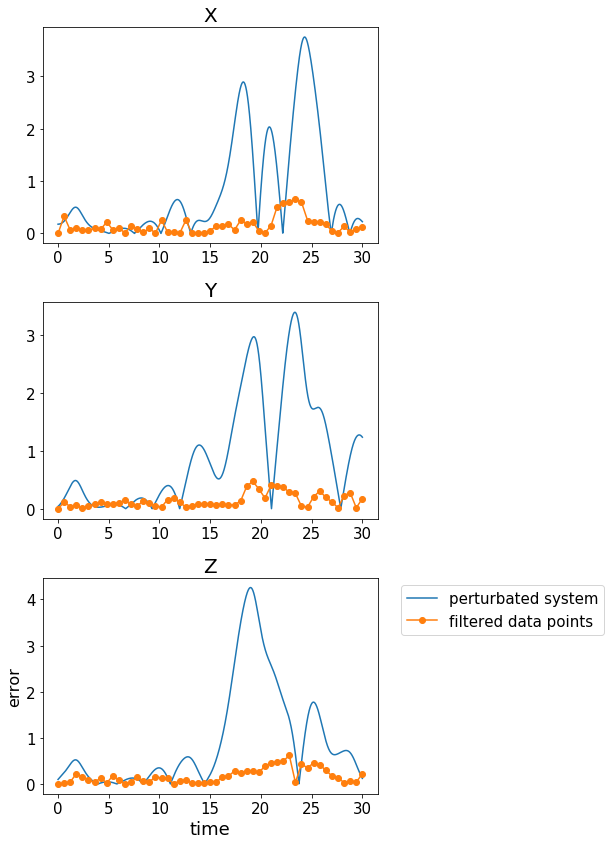

In [29]:
# error at point 1
error_pert_x = np.abs(x - x_pert)
error_pert_y = np.abs(y - y_pert)
error_pert_z = np.abs(z - z_pert)

# error at point 2
error_filtered_x_ensemble = np.empty(shape = len(timestamp))
error_filtered_y_ensemble = np.empty(shape = len(timestamp))
error_filtered_z_ensemble = np.empty(shape = len(timestamp))


for i in range(0, len(timestamp)):
    error_filtered_x_ensemble[i] = np.abs(x[dt*i] - processed_mean[0, i])
    error_filtered_y_ensemble[i] = np.abs(y[dt*i] - processed_mean[1, i])
    error_filtered_z_ensemble[i] = np.abs(z[dt*i] - processed_mean[2, i])

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(np.linspace(0, 30, len(x)), error_pert_x, label = 'perturbated system')
axs[0].plot(timestamp, error_filtered_x_ensemble, '-o', label = 'filtered data points')
axs[0].set_title('X', fontsize = 20)
axs[1].plot(np.linspace(0, 30, len(x)), error_pert_y, label = 'perturbated system')
axs[1].plot(timestamp, error_filtered_y_ensemble, '-o', label = 'filtered data points')
axs[1].set_title('Y', fontsize = 20)
axs[2].plot(np.linspace(0, 30, len(x)), error_pert_z, label = 'perturbated system')
axs[2].plot(timestamp, error_filtered_z_ensemble, '-o', label = 'filtered data points')
axs[2].set_title('Z', fontsize = 20)

plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()

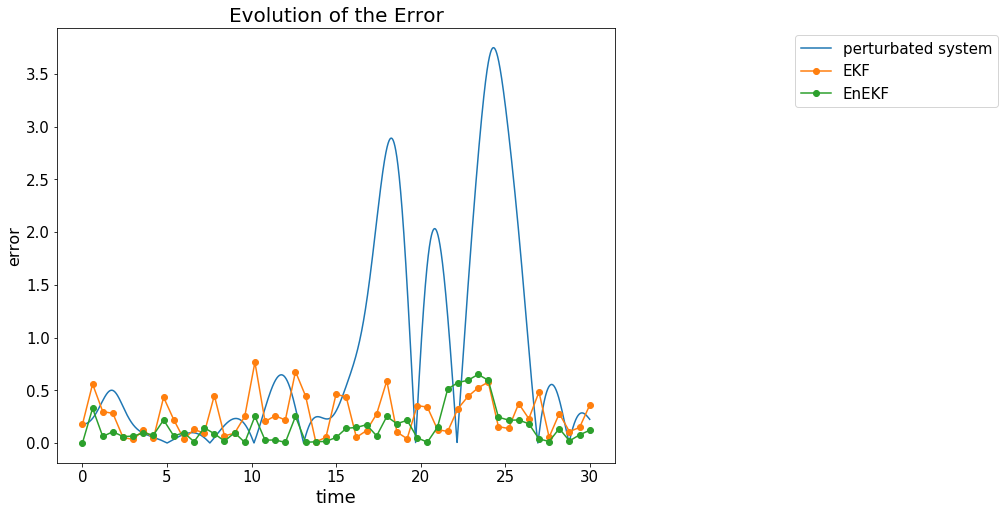

In [30]:
plt.plot(np.linspace(0, 30, len(x)), error_pert_x, label = 'perturbated system')
plt.plot(timestamp, error_filtered_x, '-o', label = 'EKF')
plt.plot(timestamp, error_filtered_x_ensemble, '-o', label = 'EnEKF')

plt.title('Evolution of the Error', fontsize = 20)
plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()

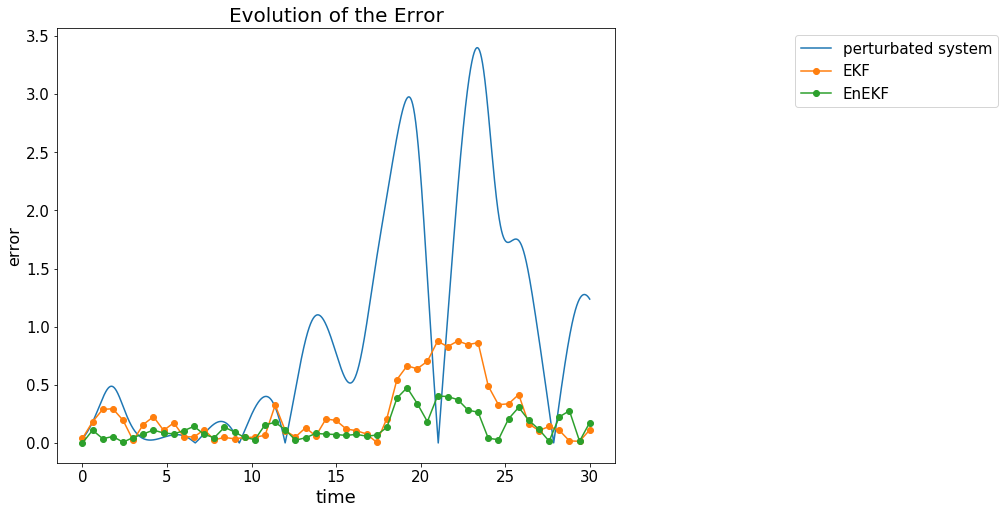

In [31]:
plt.plot(np.linspace(0, 30, len(y)), error_pert_y, label = 'perturbated system')
plt.plot(timestamp, error_filtered_y, '-o', label = 'EKF')
plt.plot(timestamp, error_filtered_y_ensemble, '-o', label = 'EnEKF')

plt.title('Evolution of the Error', fontsize = 20)
plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()

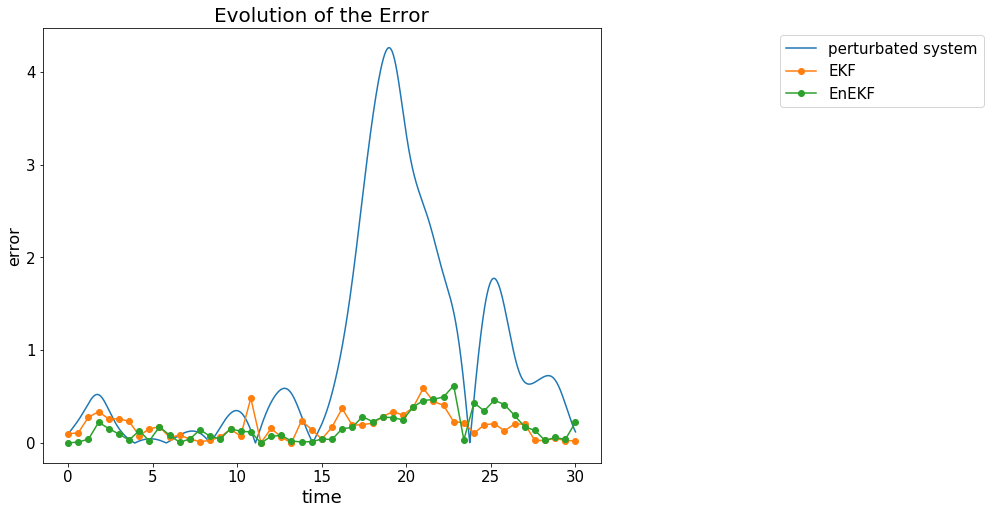

In [32]:
plt.plot(np.linspace(0, 30, len(z)), error_pert_z, label = 'perturbated system')
plt.plot(timestamp, error_filtered_z, '-o', label = 'EKF')
plt.plot(timestamp, error_filtered_z_ensemble, '-o', label = 'EnEKF')

plt.title('Evolution of the Error', fontsize = 20)
plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()